<a href="https://colab.research.google.com/github/kimkynningsrud/MasterThesis2024/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning using DTW - Master Thesis 2024

To do:
- Implement other functions to measure dataset similarity
  - Look at ccf? Find some other metrics.
- Implement transfer learning framework
  - Need datasets that can be made to tensors. Currently only the stock price dataset is this way. (only if LSTM is to be used). Initially, implement other models that do not require this.


What this code does:
- Imports all datasets and puts them in a dictionary
- Preprocessing (sets datetime, removing Nan, slicing to relevant timeframe etc.)
- Dynamic Time Warping (DTW) for all datasets in dictionary
- Finds Cross-correlation for all datasets in dictionary
- Splits all datasets into train and test sets.
- Creates machine learning models (RNN, MLP) and trains on all train sets and predicts for all test sets.

## Importing Packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#pip install dtaidistance
from dtaidistance import dtw
from scipy.spatial.distance import euclidean
import tensorflow as tf
import warnings
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import correlate



warnings.filterwarnings('ignore')

## Importing Data
Here we also make sure the datasets are on the correct format to be able to go through the following functions.
Requirements:
  - Temporal sequence of interest should be in the last column.
  - Column containing data must be named 'Date'

In [21]:
# Stock prices dataset
stock_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/indexData.csv?token=GHSAT0AAAAAACML34ERF76CZOWCJEXGGYJYZNPUR6A"
stock_prices = pd.read_csv(stock_prices_url)
stock_prices_shenzhen = stock_prices[stock_prices['Index'] == '399001.SZ']
stock_prices_nya = stock_prices[stock_prices['Index'] == 'NYA']
stock_prices_nasdaq = stock_prices[stock_prices['Index'] == 'IXIC']

# gold prices dataset
gold_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/Gold%20Price.csv"
gold_prices = pd.read_csv(gold_prices_url)

# petrolium prices dataset
petrolium_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/PET_PRI_GND_DCUS_NUS_W.csv"
petrolium_prices = pd.read_csv(petrolium_prices_url)

# btc price dataset
btc_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/BTC-USD.csv"
btc_prices = pd.read_csv(btc_prices_url)

# dollar index value
usdollar_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/US%20Dollar%20Index%20Historical%20Data.csv"
usdollar_prices = pd.read_csv(usdollar_prices_url)

# unemployment rates

#

#

#
#other datasets also go here. If the list of datasets grows too long, consider urls in list.

datasets = {
    "Shenzhen Stock Index": stock_prices_shenzhen,
    "NYA Stock Index": stock_prices_nya,
    "NASDAQ Stock Index": stock_prices_nasdaq,
    "Gold Prices": gold_prices,
    "Petrolium Prices": petrolium_prices,
    "BTC Prices": btc_prices,
    "US Dollar Index Value": usdollar_prices
}


In [3]:
stock_prices.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0


In [4]:
gold_prices.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,2014-01-01,29542,29435,29598,29340,2930,0.25
1,2014-01-02,29975,29678,30050,29678,3140,1.47
2,2014-01-03,29727,30031,30125,29539,3050,-0.83
3,2014-01-04,29279,29279,29279,29279,0,-1.51
4,2014-01-06,29119,29300,29395,29051,24380,-0.55


In [5]:
# moving the "A1" to the back of the dataframe as this is needed for the DTW. "A1" is the temporal column of interest.
A1col = petrolium_prices.pop("A1")
petrolium_prices.insert(len(petrolium_prices.columns), "A1", A1col)
petrolium_prices.head()

,Date,A2,A3,R1,R2,R3,M1,M2,M3,P1,P2,P3,D1,A1
0,01/02/1995,1.104,1.231,1.079,1.063,1.167,1.170,1.159,1.298,1.272,1.250,1.386,1.104,1.127
1,01/09/1995,1.111,1.232,1.086,1.070,1.169,1.177,1.164,1.300,1.279,1.256,1.387,1.102,1.134
2,01/16/1995,1.102,1.231,1.078,1.062,1.169,1.168,1.155,1.299,1.271,1.249,1.385,1.100,1.126
3,01/23/1995,1.110,1.226,1.083,1.068,1.165,1.177,1.165,1.296,1.277,1.256,1.378,1.095,1.132
4,01/30/1995,1.109,1.221,1.083,1.068,1.162,1.176,1.163,1.291,1.275,1.255,1.370,1.090,1.131


In [6]:
open_p = btc_prices.pop("Open")
btc_prices.insert(len(btc_prices.columns), "Open", open_p)
btc_prices.tail()


,Date,High,Low,Close,Adj Close,Volume,Open
3223,2023-07-15,30407.781250,30263.462891,30295.806641,30295.806641,8011667756,30331.783203
3224,2023-07-16,30437.560547,30089.669922,30249.132813,30249.132813,8516564470,30297.472656
3225,2023-07-17,30336.400391,29685.783203,30145.888672,30145.888672,13240156074,30249.626953
3226,2023-07-18,30233.656250,29556.427734,29856.562500,29856.562500,13138897269,30147.070313
3227,2023-07-20,30224.115234,29918.281250,30189.902344,30189.902344,11906640896,29919.064453


In [7]:
usdprice = usdollar_prices.pop("Price")
usdollar_prices.insert(len(usdollar_prices.columns), "Price", usdprice)
usdollar_prices.tail()

,Date,Open,High,Low,Change %,Price
5618,"Sep 15, 2022",109.60,109.92,109.42,0.19%,109.80
5619,"Sep 16, 2022",109.80,110.26,109.48,-0.14%,109.64
5620,"Sep 18, 2022",109.64,109.74,109.50,-0.08%,109.55
5621,"Sep 19, 2022",109.55,110.18,109.49,-0.01%,109.54
5622,"Sep 20, 2022",109.54,110.23,109.36,0.53%,110.12


## Pre-processing

In [8]:
def convert_dates(df, date_column='Date'):
    """
    Converts the date column to datetime format, relying on Pandas to infer the date format.

    :param df: Pandas DataFrame containing the financial data.
    :param date_column: Name of the column containing date information.
    :return: DataFrame with the converted date column.
    """
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    return df

def trim_dataset_to_timeframe(df, date_column='Date', start_year=2015, end_year=2020):
    """
    Trims the dataset to include data only between the specified start and end years.

    :param dataset: Pandas DataFrame containing the data.
    :param date_column: The name of the column containing the date information.
    :param start_year: The start year for the timeframe.
    :param end_year: The end year for the timeframe.
    :return: Trimmed DataFrame.
    """
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])

    # Filter the dataset based on the date range
    start_date = pd.Timestamp(year=start_year, month=1, day=1)
    end_date = pd.Timestamp(year=end_year, month=12, day=31)
    df = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]

    return df


def handle_missing_values(df):
    """
    Detects and removes missing values.

    :param df: Pandas DataFrame.
    :return: DataFrame after removing missing values.
    """
    NA_values_before = df.isna().sum().sum()
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    NA_values_after = df.isna().sum().sum()

    print(f'There are {NA_values_before} NA values in the dataset. {NA_values_after} after removing them.')

    return df

def standardize(df, date_column='Date'):
    """
    Scales numerical columns except the date column.

    :param df: Pandas DataFrame.
    :param date_column: Name of the column containing date information to exclude from scaling.
    :return: Scaled DataFrame.
    """
    scaler = StandardScaler()
    numerical_columns = df.select_dtypes(include=['number']).columns
    numerical_columns = numerical_columns.drop(date_column, errors='ignore')  # Exclude date column if present

    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df

def trim_to_date_and_last_column(df):
    """
    Keeps only the 'Date' column and the last column in the DataFrame.

    :param df: Pandas DataFrame to trim.
    :return: Trimmed DataFrame with only the 'Date' column and the last data column.
    """
    if 'Date' in df.columns and len(df.columns) > 1:
        # Selecting only the 'Date' column and the last column of the DataFrame
        return df[['Date', df.columns[-1]]]
    else:
        print("Error: DataFrame must contain a 'Date' column and at least one other column.")
        return None  # Returning None to indicate that the required condition is not met



def normalize_minmax(df, columns=None):
    """
    Normalizes the specified columns of a DataFrame using Min-Max scaling.

    :param df: DataFrame to be normalized.
    :param columns: List of column names to normalize. If None, all numeric columns will be normalized.
    :return: DataFrame with normalized columns.
    """
    scaler = MinMaxScaler()
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns
    df[columns] = scaler.fit_transform(df[columns])
    return df


def stationarize_columns(df):
    """
    Processes each numeric column in the DataFrame by checking for stationarity
    and making it stationary if needed.

    :param df: DataFrame containing the time series data.
    :return: DataFrame with all necessary columns processed for stationarity.
    """
    for column in df.select_dtypes(include=['number']).columns:
        print(f"Processing column: {column}")

        # Check for stationarity
        series = df[column]
        result = adfuller(series, autolag='AIC')
        p_value = result[1]

        if p_value < 0.05:
            print(f"Column {column} is already stationary")
        else:
            # Make the series stationary if not stationary
            print(f"Making column {column} stationary")
            df[column] = df[column].diff().dropna()

    return df



def preprocess_datasets(datasets, scaled):

    preprocessed_datasets = {}

    lowest_frequency = None

    for name, df in datasets.items():
        print("_________________________________________________")
        print(f"Preprocessing {name}")
        preprocessed_df = convert_dates(df)
        preprocessed_df = trim_to_date_and_last_column(preprocessed_df)
        preprocessed_df = handle_missing_values(preprocessed_df)
        preprocessed_df = trim_dataset_to_timeframe(preprocessed_df)
        #preprocessed_df = standardize(preprocessed_df)
        #preprocessed_df = stationarize_columns(preprocessed_df)

        if scaled==True:
            preprocessed_df = normalize_minmax(preprocessed_df)


        preprocessed_datasets[name] = preprocessed_df


        # Calculate frequency
        frequency = preprocessed_df['Date'].diff().max()  # Maximum difference between dates
        if lowest_frequency is None or frequency > lowest_frequency:
            lowest_frequency = frequency

    # Resample datasets to the lowest frequency
    for name, df in preprocessed_datasets.items():
        print(f"Resampling {name} to frequency {lowest_frequency}")
        df = df.set_index('Date').resample(lowest_frequency).last().dropna().reset_index()
        preprocessed_datasets[name] = df

    return preprocessed_datasets

In [9]:
# Preprocess all datasets
preprocessed_datasets = preprocess_datasets(datasets, scaled=True)



_________________________________________________
Preprocessing Shenzhen Stock Index
There are 168 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing NYA Stock Index
There are 1 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing NASDAQ Stock Index
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing Gold Prices
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing Petrolium Prices
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing BTC Prices
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing US Dollar Index Value
There are 0 NA values in the dataset. 0 after removing them.
Resam

## Plotting after preprocessing

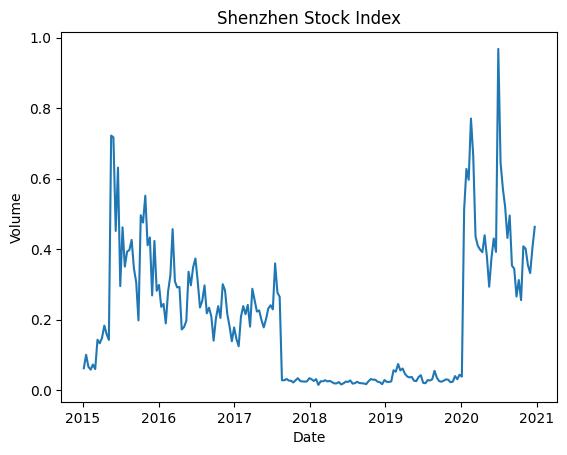

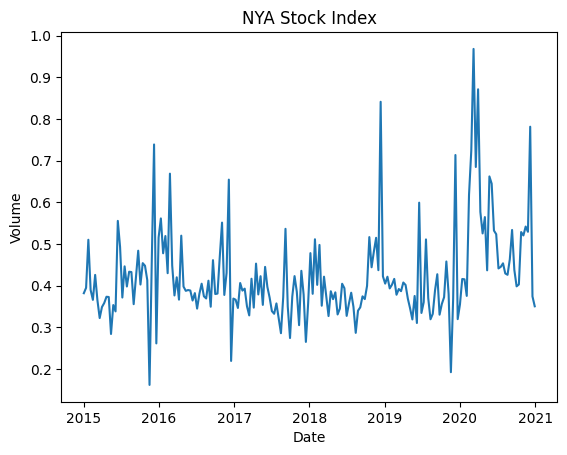

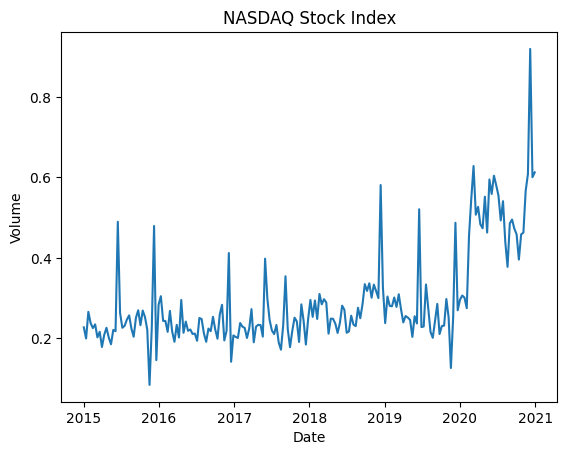

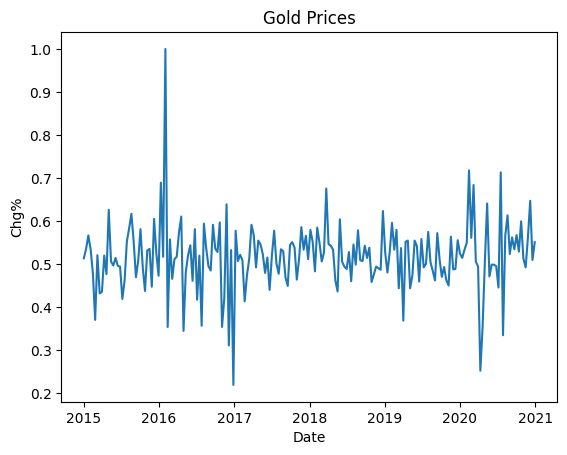

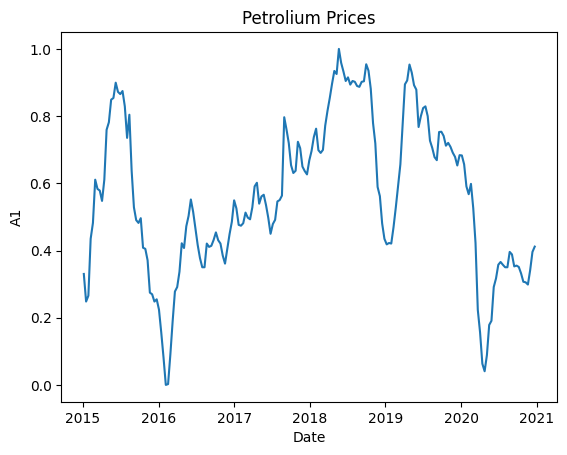

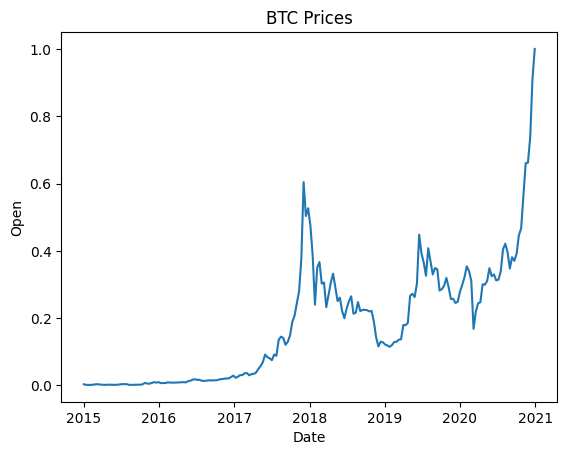

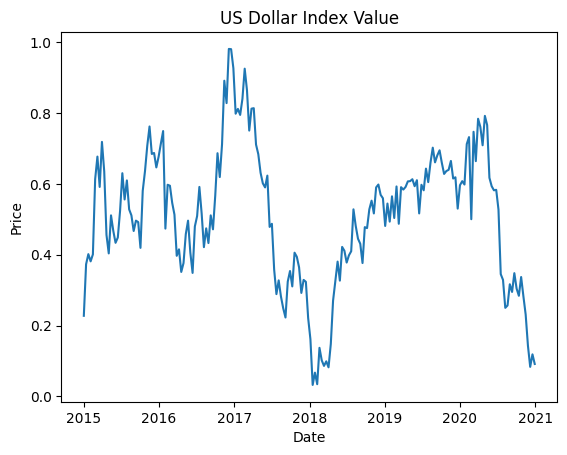

In [10]:
def plot_datasets(datasets):
    """
    Automatically plots each dataset with 'Date' on the x-axis and the last column on the y-axis.

    :param datasets: Dictionary of preprocessed datasets with their names as keys.
    """
    for name, df in datasets.items():
        plt.figure()
        last_column = df.columns[-1]  # Assuming the last column is the one to be plotted
        sns.lineplot(data=df, x='Date', y=last_column).set(title=f"{name}")
        plt.show()

# Run the function for all the datasets
plot_datasets(preprocessed_datasets)


## Dynamic Time Warping (DTW)

In [11]:
def compare_datasets_with_dtw(datasets, plot_alignments=False):
    """
    Compares each dataset to every other dataset using Dynamic Time Warping (DTW).
    Assumes the column of interest is the last one in each dataset. Optionally plots the alignments.

    :param datasets: Dictionary of Pandas DataFrames, each representing a time series dataset.
    :param plot_alignments: Boolean, whether to plot the time series alignments.
    :return: A DataFrame of DTW distances between each pair of datasets.
    """
    # Extract the last column from each dataset
    sequences = [df.iloc[:, -1].values for df in datasets.values()]

    # Compute the DTW distance matrix
    distance_matrix = dtw.distance_matrix_fast(sequences)

    dataset_names = list(datasets.keys())
    return pd.DataFrame(distance_matrix, index=dataset_names, columns=dataset_names)

# Use the function on the preprocessed datasets and plot alignments
dtw_df = compare_datasets_with_dtw(preprocessed_datasets, plot_alignments=True)


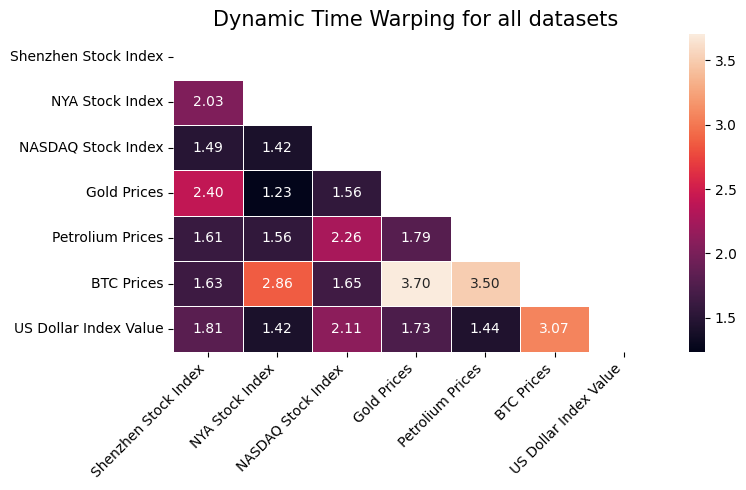

In [12]:
plt.figure(figsize=(8, 5))
mask = np.triu(np.ones_like(dtw_df, dtype=bool))
sns.heatmap(dtw_df, annot=True, fmt=".2f", linewidths=.5, cbar=True, mask=mask)
plt.title("Dynamic Time Warping for all datasets", fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Cross-correlation

In [13]:
def compare_datasets_with_cross_correlation(datasets):
    """
    Compares each dataset to every other dataset using cross-correlation.
    Assumes the column of interest is the last one in each dataset.

    :param datasets: Dictionary of Pandas DataFrames, each representing a time series dataset.
    :return: A DataFrame of cross-correlation scores between each pair of datasets.
    """
    dataset_names = list(datasets.keys())
    n = len(dataset_names)
    cross_corr_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            # Extract the last column from each dataset for comparison
            series_i = datasets[dataset_names[i]].iloc[:, -1].dropna().values
            series_j = datasets[dataset_names[j]].iloc[:, -1].dropna().values

            # Compute cross-correlation
            corr = correlate(series_i, series_j, mode='full')
            max_corr = np.max(corr)
            cross_corr_matrix[i, j] = cross_corr_matrix[j, i] = max_corr

    return pd.DataFrame(cross_corr_matrix.round(2), index=dataset_names, columns=dataset_names)

cross_corr_df = compare_datasets_with_cross_correlation(preprocessed_datasets)

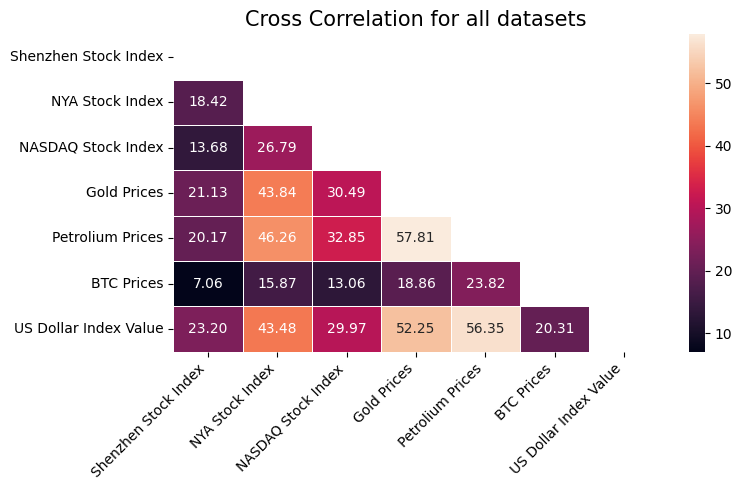

In [14]:
plt.figure(figsize=(8, 5))
mask = np.triu(np.ones_like(dtw_df, dtype=bool))
sns.heatmap(cross_corr_df, annot=True, fmt=".2f", linewidths=.5, cbar=True, mask=mask)
plt.title("Cross Correlation for all datasets", fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Test-Train split

In [15]:
def prepare_data(df, time_steps=1):
    """
    Converts the DataFrame into two arrays X and y, where X is an array of sequences of past observations
    and y is the array of corresponding future values that we want to predict.
    """
    df = df.iloc[:, -1].values  # Using only the last column
    df = df.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    df = scaler.fit_transform(df)

    X, y = [], []
    for i in range(time_steps, len(df)):
        X.append(df[i-time_steps:i, 0])
        y.append(df[i, 0])

    return np.array(X), np.array(y)

# Function to split datasets into train and test
def split_datasets(datasets, time_steps, test_size=0.2):
    train_test_split_datasets = {}
    for name, df in datasets.items():
        X, y = prepare_data(df, time_steps)
        X = X.reshape(X.shape[0], X.shape[1], 1)
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
        train_test_split_datasets[name] = (train_X, train_y, test_X, test_y)
    return train_test_split_datasets

## Model Creation

In [16]:
preprocessed_datasets = preprocess_datasets(datasets, scaled=False)

_________________________________________________
Preprocessing Shenzhen Stock Index
There are 168 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing NYA Stock Index
There are 1 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing NASDAQ Stock Index
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing Gold Prices
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing Petrolium Prices
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing BTC Prices
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing US Dollar Index Value
There are 0 NA values in the dataset. 0 after removing them.
Resam

In [17]:
# Function to prepare data
def prepare_data(df, time_steps=1):
    """
    Converts DataFrame into X, y arrays without scaling.
    """
    df = df.iloc[:, -1].values  # Using only the last column
    df = df.reshape(-1, 1)

    X, y = [], []
    for i in range(time_steps, len(df)):
        X.append(df[i-time_steps:i, 0])
        y.append(df[i, 0])

    return np.array(X), np.array(y)

# Function to split datasets into train and test and scale data
def split_datasets(datasets, time_steps, test_size=0.2):
    train_test_split_datasets = {}
    scalers = {}
    for name, df in datasets.items():
        scaler = MinMaxScaler(feature_range=(0, 1))
        df_scaled = scaler.fit_transform(df.iloc[:, -1].values.reshape(-1, 1))

        X, y = prepare_data(pd.DataFrame(df_scaled), time_steps)
        X = X.reshape(X.shape[0], X.shape[1], 1)
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)

        train_test_split_datasets[name] = (train_X, train_y, test_X, test_y)
        scalers[name] = scaler

    return train_test_split_datasets, scalers

# Function to create an RNN model
def create_rnn_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to train the RNN model using transfer learning
def train_with_transfer_learning(split_datasets, base_model=None):
    trained_models = {}
    for name, (train_X, train_y, test_X, test_y) in split_datasets.items():
        print(f"Training on {name}")

        # If it's the first model, create a new one; otherwise, use the base model
        if base_model is None:
            model = create_rnn_model(train_X.shape[1:])  # input_shape is the shape of X excluding the sample axis
        else:
            model = tf.keras.models.clone_model(base_model)
            # Re-compile the model after cloning
            model.compile(optimizer='adam', loss='mean_squared_error')

        early_stopping = EarlyStopping(monitor='val_loss', patience=15)
        model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=10, callbacks=[early_stopping])

        trained_models[name] = model
        base_model = model  # Update the base model for transfer learning

    return trained_models

# Define time_steps
time_steps = 5  # Adjust based on your datasets

# Split the datasets and get scalers
split_data, scalers = split_datasets(preprocessed_datasets, time_steps)

# Train the models using transfer learning
trained_models = train_with_transfer_learning(split_data)

# Function to evaluate models on test data
def evaluate_models_on_test_data(trained_models, split_datasets, scalers):
    evaluation_results = {}
    for train_name, model in trained_models.items():
        evaluation_results[train_name] = {}
        for test_name, (test_X, test_y, _, _) in split_datasets.items():
            predictions = model.predict(test_X)

            # Inverse scaling predictions
            predictions = scalers[test_name].inverse_transform(predictions)
            test_y_unscaled = scalers[test_name].inverse_transform(test_y.reshape(-1, 1))

            evaluation_results[train_name][test_name] = {
                'MSE': mean_squared_error(test_y_unscaled, predictions),
                'RMSE': np.sqrt(mean_squared_error(test_y_unscaled, predictions)),
                'MAE': mean_absolute_error(test_y_unscaled, predictions),
                'R2': r2_score(test_y_unscaled, predictions)
            }

    return evaluation_results

# Evaluate the models on test data
evaluation_results = evaluate_models_on_test_data(trained_models, split_data, scalers)


Training on Shenzhen Stock Index
Epoch 1/10
5/5 [==============================] - 17s 818ms/step - loss: 0.0391 - val_loss: 0.0997
Epoch 2/10
5/5 [==============================] - 0s 48ms/step - loss: 0.0199 - val_loss: 0.0490
Epoch 3/10
5/5 [==============================] - 0s 33ms/step - loss: 0.0184 - val_loss: 0.0460
Epoch 4/10
5/5 [==============================] - 0s 36ms/step - loss: 0.0145 - val_loss: 0.0547
Epoch 5/10
5/5 [==============================] - 0s 29ms/step - loss: 0.0124 - val_loss: 0.0534
Epoch 6/10
5/5 [==============================] - 0s 67ms/step - loss: 0.0108 - val_loss: 0.0481
Epoch 7/10
5/5 [==============================] - 0s 50ms/step - loss: 0.0113 - val_loss: 0.0508
Epoch 8/10
5/5 [==============================] - 0s 69ms/step - loss: 0.0109 - val_loss: 0.0519
Epoch 9/10
5/5 [==============================] - 0s 38ms/step - loss: 0.0107 - val_loss: 0.0491
Epoch 10/10
5/5 [==============================] - 0s 65ms/step - loss: 0.0104 - val_loss: 0

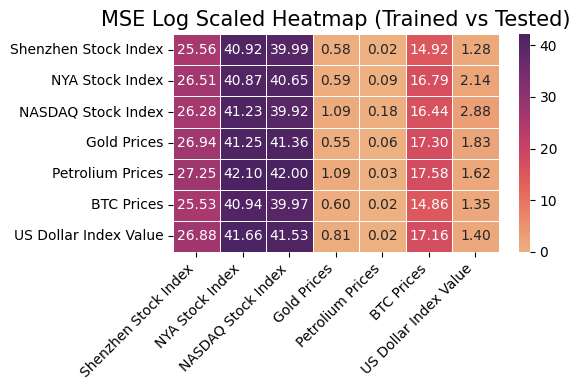

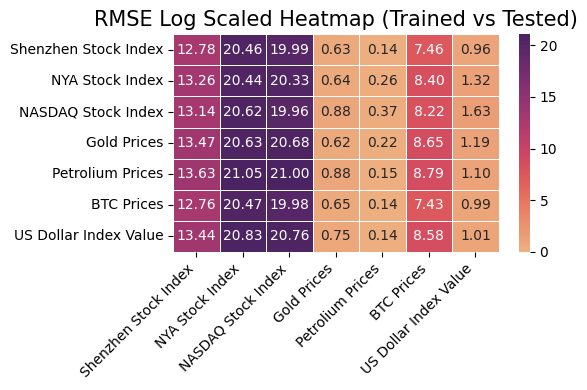

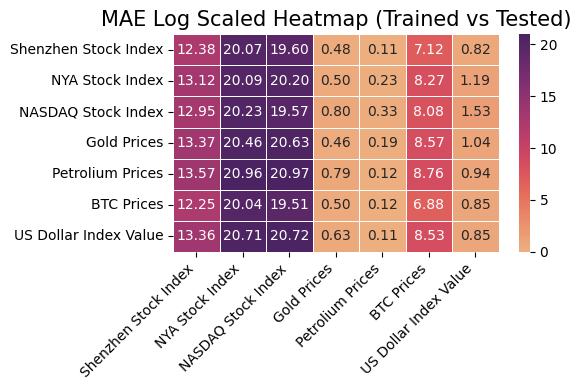

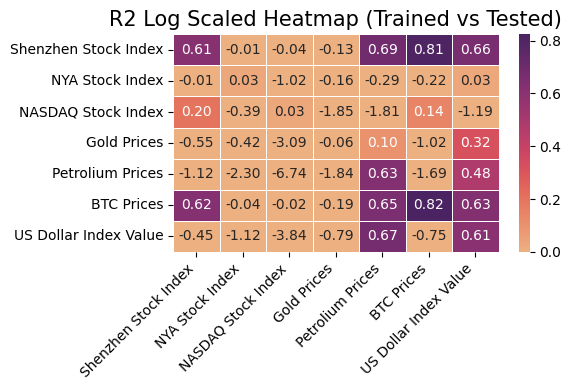

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize empty DataFrames for each metric
metrics = ['MSE', 'RMSE', 'MAE', 'R2']
metric_dfs = {metric: pd.DataFrame(index=evaluation_results.keys(), columns=evaluation_results.keys()) for metric in metrics}

# Populate the DataFrames with evaluation results
for train_name in evaluation_results:
    for test_name in evaluation_results[train_name]:
        for metric in metrics:
            value = evaluation_results[train_name][test_name][metric]
            metric_dfs[metric].loc[train_name, test_name] = np.log1p(value) if metric != 'R2' else value  # Apply log scale for error metrics

# Convert all values to numeric
for metric in metrics:
    metric_dfs[metric] = metric_dfs[metric].apply(pd.to_numeric, errors='coerce')

# Generate heatmaps for each metric
def generate_heatmap(df, title, is_r2=False):
    plt.figure(figsize=(6, 4))
    vmax = None if is_r2 else df.max().max()  # Set a max value for color scale if not R2
    sns.heatmap(df, annot=True, fmt=".2f", linewidths=.5, cbar=True, vmin=0, vmax=vmax, cmap='flare')
    plt.title(title, fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

for metric, df in metric_dfs.items():
    generate_heatmap(df, f"{metric} Log Scaled Heatmap (Trained vs Tested)", is_r2=(metric == 'R2'))


## Ensemble

Training on Shenzhen Stock Index
Epoch 1/10
5/5 [==============================] - 1s 4ms/step - loss: 881735106560.0000
Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 810499506176.0000
Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 745228730368.0000
Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 681535537152.0000
Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 622494220288.0000
Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 566953902080.0000
Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 510500241408.0000
Epoch 8/10
5/5 [==============================] - 0s 4ms/step - loss: 464116154368.0000
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 415040634880.0000
Epoch 10/10
5/5 [==============================] - 0s 4ms/step - loss: 371541737472.0000
Training on NYA Stock Index
Epoch 1/10
5/5 [==============================] - 0s 3ms/s

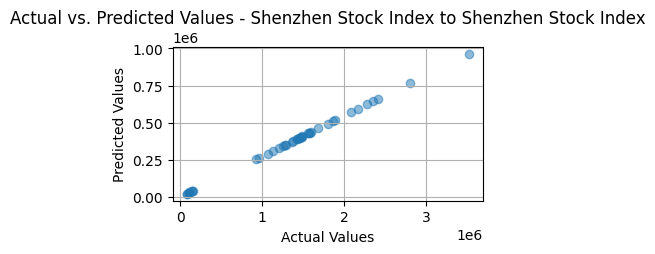

2/2 [==============================] - 0s 4ms/step


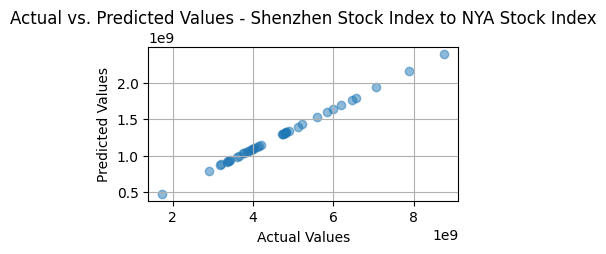

2/2 [==============================] - 0s 6ms/step


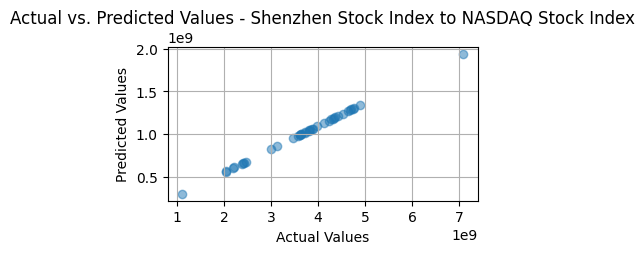

2/2 [==============================] - 0s 6ms/step


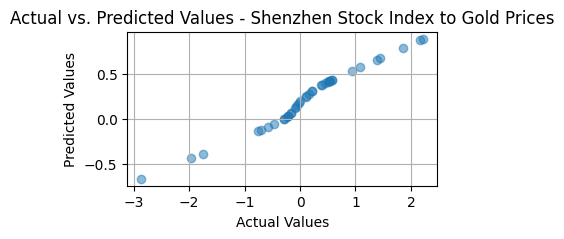

2/2 [==============================] - 0s 5ms/step


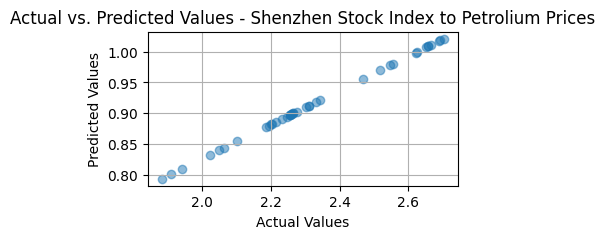

2/2 [==============================] - 0s 5ms/step


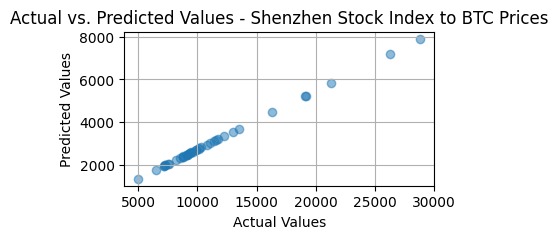

2/2 [==============================] - 0s 5ms/step


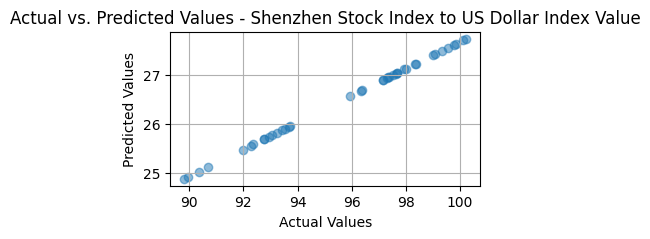

2/2 [==============================] - 0s 6ms/step


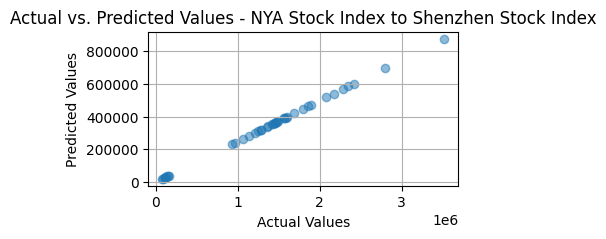

2/2 [==============================] - 0s 5ms/step


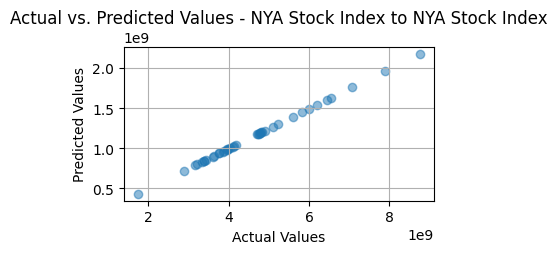

2/2 [==============================] - 0s 11ms/step


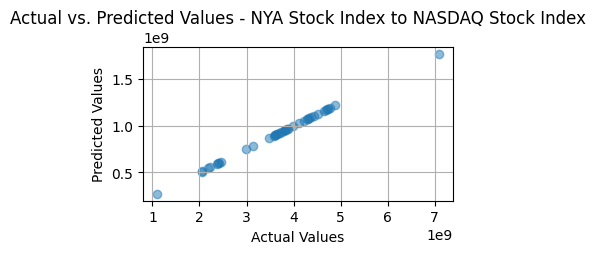

2/2 [==============================] - 0s 6ms/step


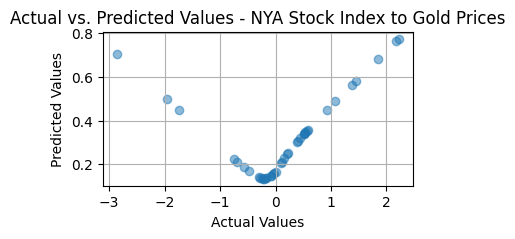

2/2 [==============================] - 0s 6ms/step


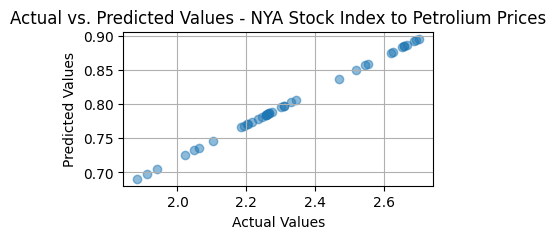

2/2 [==============================] - 0s 7ms/step


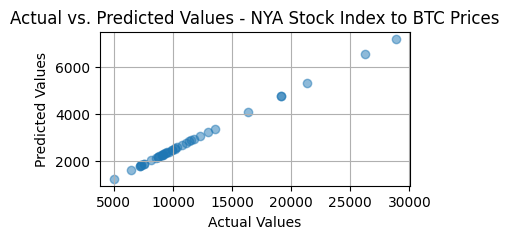

2/2 [==============================] - 0s 6ms/step


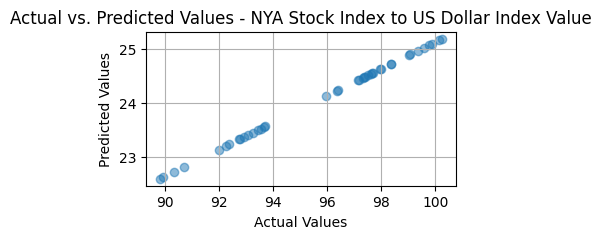

2/2 [==============================] - 0s 6ms/step


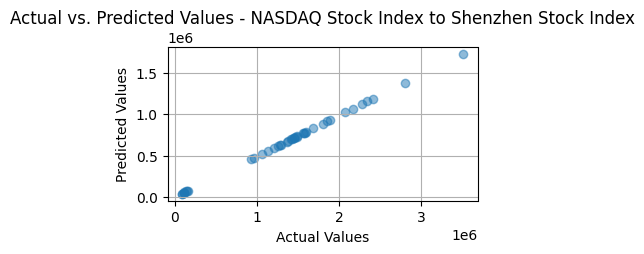

2/2 [==============================] - 0s 7ms/step


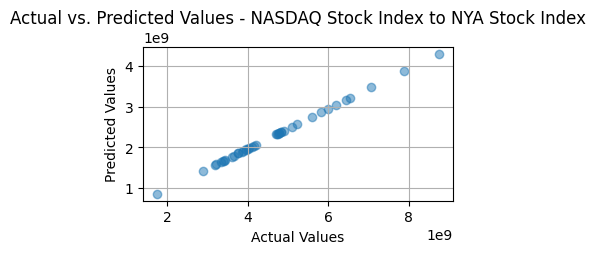

2/2 [==============================] - 0s 7ms/step


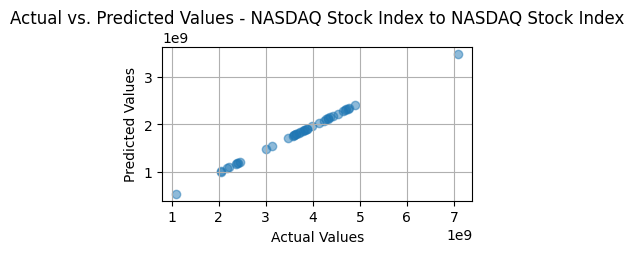

2/2 [==============================] - 0s 6ms/step


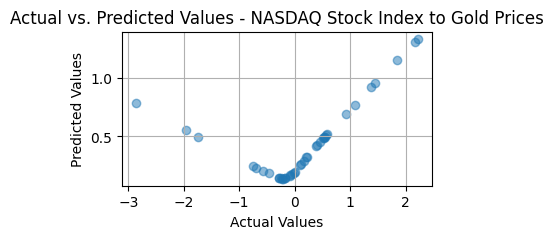

2/2 [==============================] - 0s 5ms/step


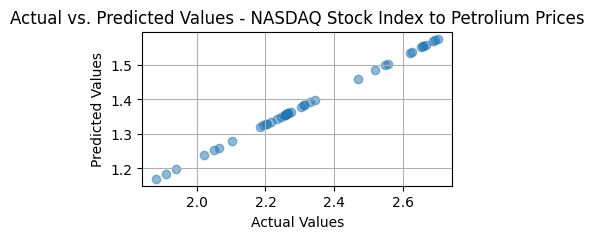

2/2 [==============================] - 0s 6ms/step


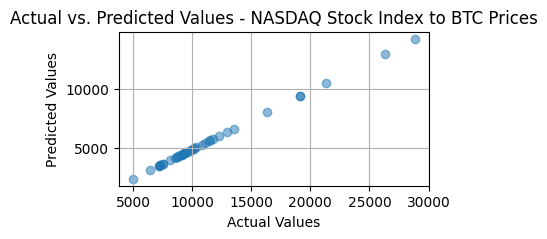

2/2 [==============================] - 0s 14ms/step


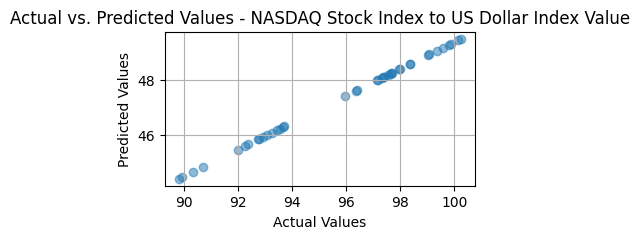

2/2 [==============================] - 0s 5ms/step


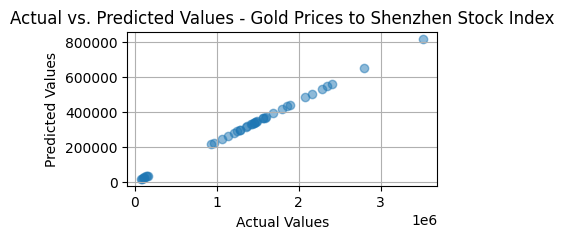

2/2 [==============================] - 0s 8ms/step


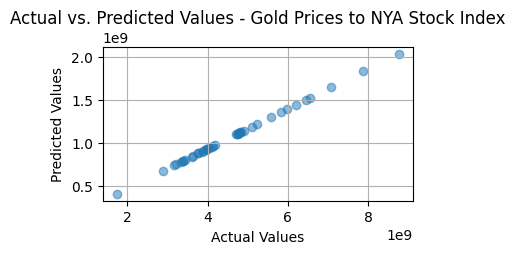

2/2 [==============================] - 0s 5ms/step


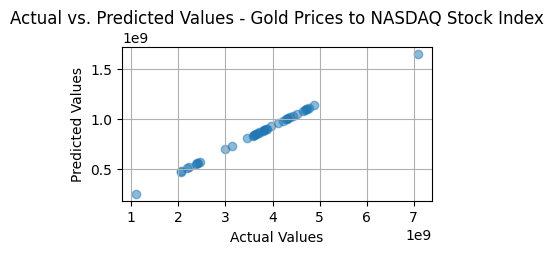

2/2 [==============================] - 0s 7ms/step


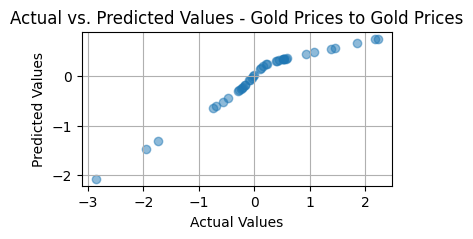

2/2 [==============================] - 0s 5ms/step


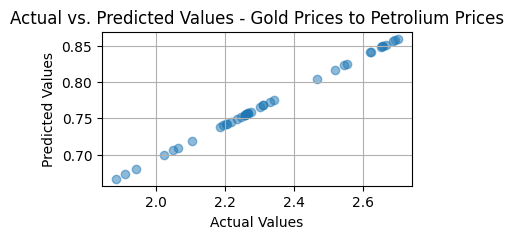

2/2 [==============================] - 0s 7ms/step


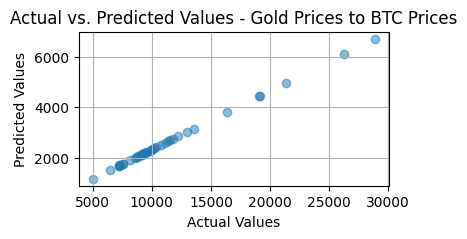

2/2 [==============================] - 0s 6ms/step


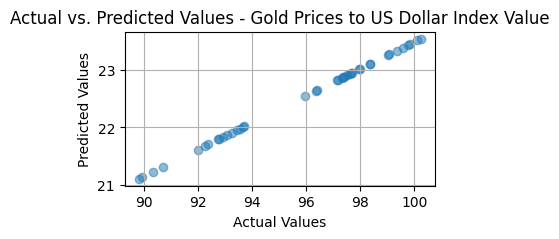

2/2 [==============================] - 0s 6ms/step


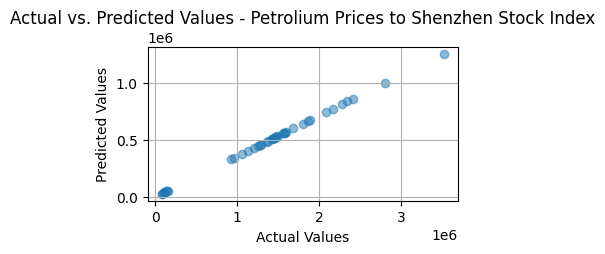

2/2 [==============================] - 0s 6ms/step


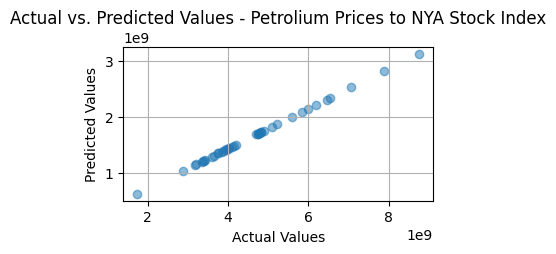

2/2 [==============================] - 0s 5ms/step


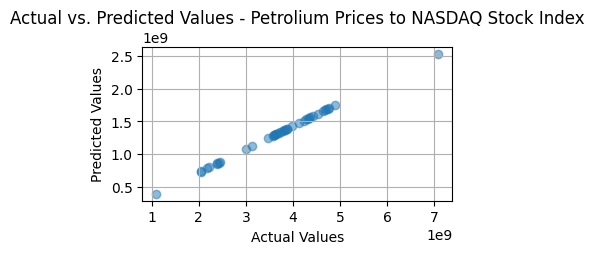

2/2 [==============================] - 0s 6ms/step


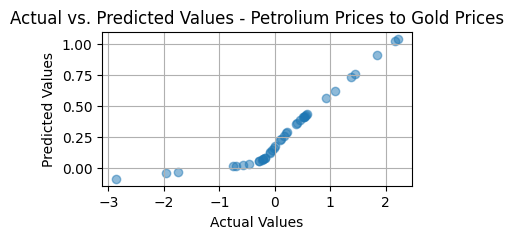

2/2 [==============================] - 0s 6ms/step


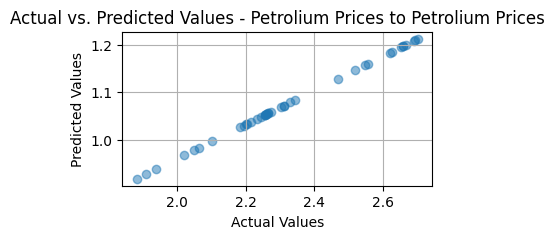

2/2 [==============================] - 0s 5ms/step


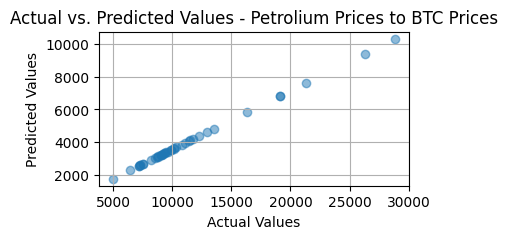

2/2 [==============================] - 0s 6ms/step


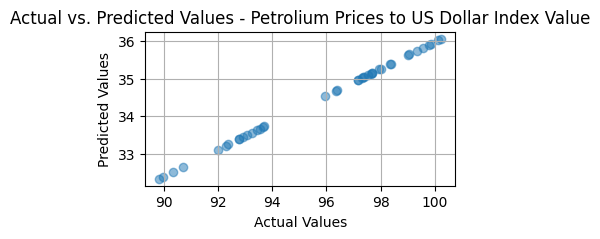

2/2 [==============================] - 0s 4ms/step


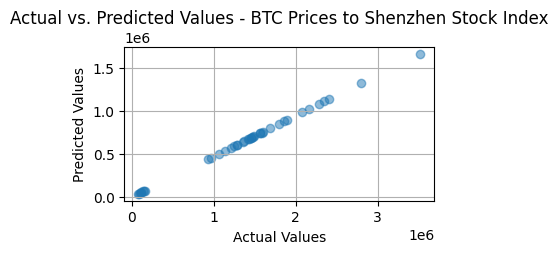

2/2 [==============================] - 0s 6ms/step


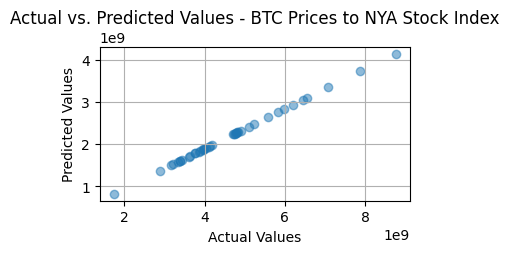

2/2 [==============================] - 0s 6ms/step


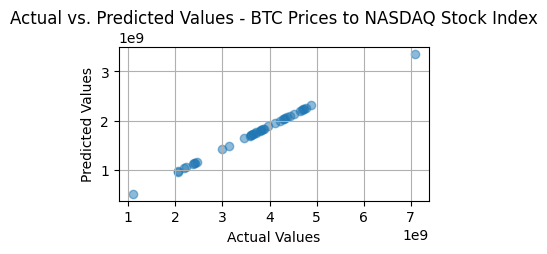

2/2 [==============================] - 0s 5ms/step


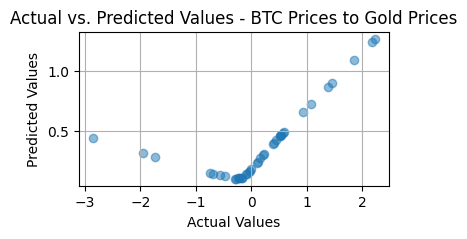

2/2 [==============================] - 0s 5ms/step


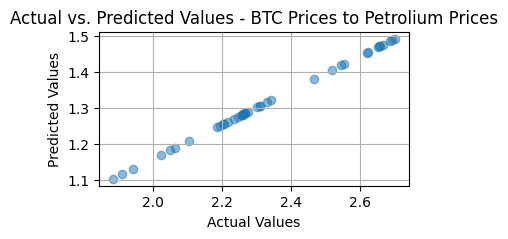

2/2 [==============================] - 0s 5ms/step


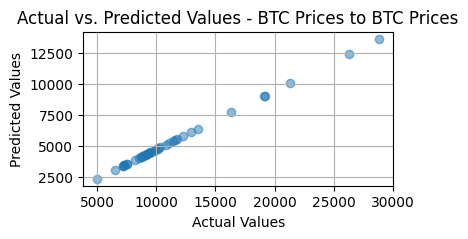

2/2 [==============================] - 0s 6ms/step


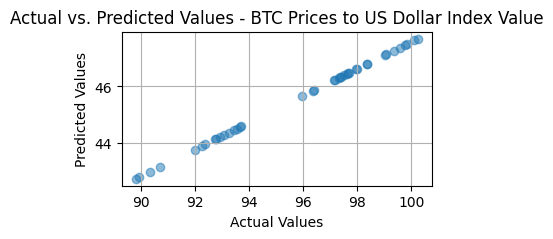

2/2 [==============================] - 0s 7ms/step


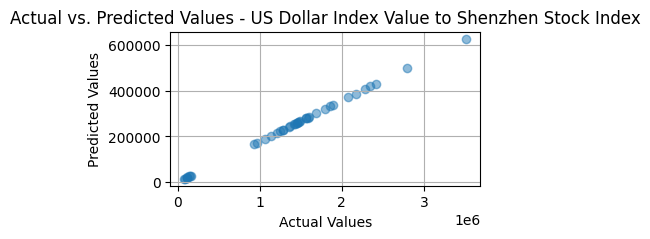

2/2 [==============================] - 0s 6ms/step


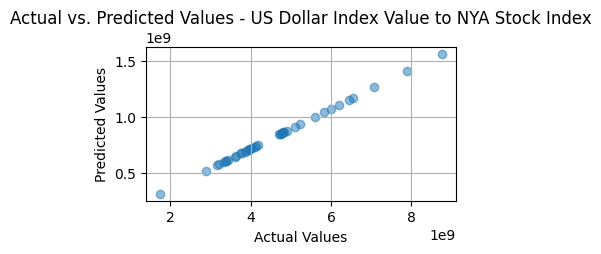

2/2 [==============================] - 0s 6ms/step


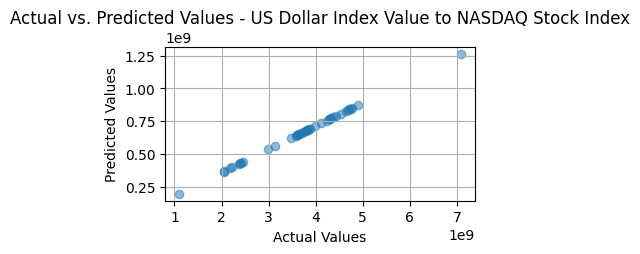

2/2 [==============================] - 0s 7ms/step


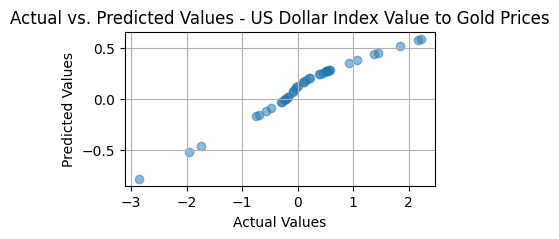

2/2 [==============================] - 0s 7ms/step


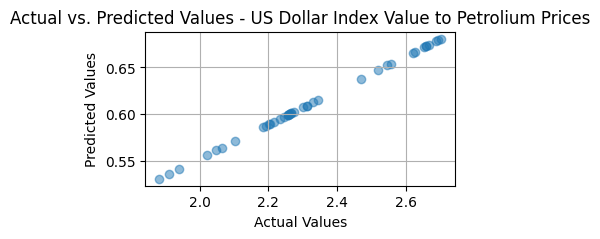

2/2 [==============================] - 0s 6ms/step


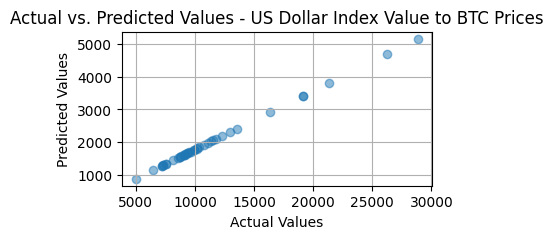

2/2 [==============================] - 0s 4ms/step


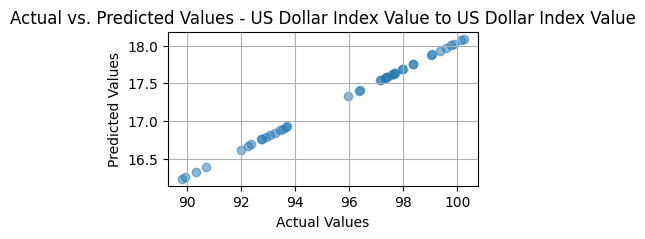

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def split_train_test(df, test_size=0.2):
    """
    Chronologically splits the DataFrame into training and testing sets.

    :param df: DataFrame to split.
    :param test_size: Proportion of the dataset to include in the test split.
    :return: train_df, test_df
    """
    split_index = int(len(df) * (1 - test_size))
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]
    return train_df, test_df

def create_mlp_model(input_shape):
    """
    Creates a shallow MLP model.

    :param input_shape: Shape of the input data.
    :return: Compiled MLP model.
    """
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_ensemble_models(datasets, create_model_func, epochs=10):
    """
    Trains ensemble models using transfer learning on all datasets.

    :param datasets: Dictionary of preprocessed datasets.
    :param create_model_func: Function to create the model.
    :param epochs: Number of training epochs.
    :return: Dictionary of trained models.
    """
    trained_models = {}
    base_model = None

    for name, df in datasets.items():
        print(f"Training on {name}")

        # Split the dataset into features and target
        X = df.drop('Date', axis=1).values
        y = df.iloc[:, -1].values  # Assuming the target variable is the last column

        # Split into train and test
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=False)

        # Train model
        if base_model is None:
            model = create_model_func(input_shape=(train_X.shape[1],))
        else:
            model = tf.keras.models.clone_model(base_model)
            model.compile(optimizer='adam', loss='mean_squared_error')

        model.fit(train_X, train_y, epochs=epochs)
        trained_models[name] = (model, test_X, test_y)
        base_model = model

    return trained_models

def evaluate_models(trained_models):
    """
    Evaluates each model on all test datasets.

    :param trained_models: Dictionary of trained models and their test sets.
    :return: DataFrame with evaluation results.
    """
    evaluation_results = pd.DataFrame(columns=trained_models.keys(), index=trained_models.keys())

    for train_name, (model, _, _) in trained_models.items():
        for test_name, (_, test_X, test_y) in trained_models.items():
            predictions = model.predict(test_X)
            mse = mean_squared_error(test_y, predictions)
            evaluation_results.loc[train_name, test_name] = mse


            plt.figure(figsize=(4, 2))
            plt.scatter(test_y, predictions, alpha=0.5)
            plt.xlabel("Actual Values")
            plt.ylabel("Predicted Values")
            plt.title(f"Actual vs. Predicted Values - {train_name} to {test_name}")
            plt.grid(True)
            plt.show()



    return evaluation_results

# Example usage
# Splitting and preprocessing should be done before calling these functions
trained_models = train_ensemble_models(preprocessed_datasets, create_mlp_model)
evaluation_results = evaluate_models(trained_models)


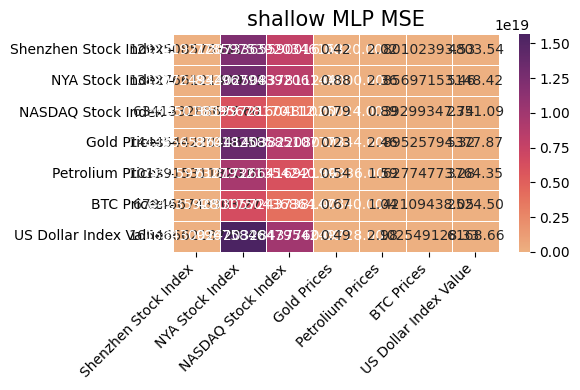

In [20]:
evaluation_results = evaluation_results.apply(pd.to_numeric, errors='coerce')  # Convert to numeric
generate_heatmap(evaluation_results, 'shallow MLP MSE')